In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.cm as cm
import matplotlib.cbook as cbook
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import warnings
warnings.filterwarnings('ignore')

# Data generation

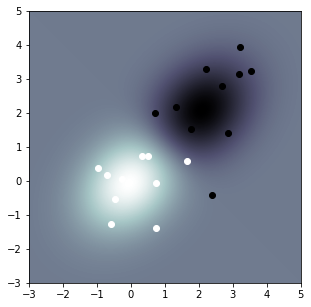

In [2]:
delta = 0.025
x = y = np.arange(-3.0, 5.0, delta)
X, Y = np.meshgrid(x, y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
rv1 = stats.multivariate_normal([0, 0], [[1, 0.3], [0.3, 1]])
Z1 = rv1.pdf(pos)
rv2 = stats.multivariate_normal([2, 2], [[1, 0.3], [0.3, 1]])
Z2 = rv2.pdf(pos)
Z = (Z1 - Z2)

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(Z, interpolation='bilinear', cmap=cm.bone,
               origin='lower', extent=[-3, 5, -3, 5],
               vmax=abs(Z).max(), vmin=-abs(Z).max())
mean, cov = [0, 0], [(1, .3), (.3, 1)]

data1 = np.random.multivariate_normal(mean, cov, 10)
df1 = pd.DataFrame(data1, columns=["x", "y"])
im = plt.scatter(df1.x, df1.y, color='white')

data2 = np.random.multivariate_normal(mean, cov, 10)
df2 = pd.DataFrame(data2+2, columns=["x", "y"])
im = plt.scatter(df2.x, df2.y, color='black')
plt.show()
fig.savefig('datagen.png', format='png', dpi=100)
fig.savefig('datagen.eps', format='eps', dpi=100)

In [3]:
#####################
# Matrix Generation #
#####################

# Tri-Diagonal Matrix
def genTriDiag( k, x, d=1 ):
    mat = np.diag([d]*k)
    off = np.diag([x]*(k-1))
    off = np.vstack((off,[0]*(k-1)))
    off = np.vstack(( [0]*k,off.T))
    mat = mat+off+off.T
    return(mat)

# Auto-Regressive Matrix
def genArMat( k, x ):
    indx = np.array(list(range(1,k+1))*k).reshape((k,k))
    indx = np.abs(indx-indx.T)
    mat  = x**indx
    return(mat)

# Banded Matrix
def genBandedMat( k, m ):
    mat = np.zeros((k,k))
    for i in range(1,m):
        off = np.diag([1-i/m]*(k-i))
        off = np.vstack((off,np.zeros((i,k-i))))
        off = np.vstack((np.zeros((i,k)),off.T))
        mat = mat + off
    mat = mat + mat.T + np.diag(np.ones(k))
    return(mat)

# Random Sparse Matrix
def genRandSpMat(k,p=0.1 ):
    msk = np.random.normal(loc=1, scale=p, size=k**2).reshape((k,k))
    rnd = np.random.uniform(0.3,0.8,k**2).reshape((k,k))
    mat = msk*rnd
    mat = mat+mat.T
    w, v = np.linalg.eig(mat)
    eig = min(min(w),0)
    mat = mat + np.diag([0.01-eig]*k)
    return(mat)

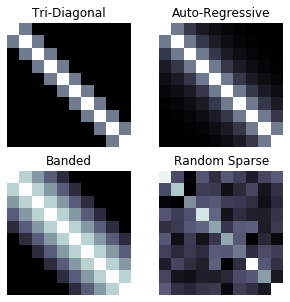

In [5]:
k=10
p=0.5
plt.figure(figsize=(5,5))
plt.subplot(2,2,1)
plt.imshow(genTriDiag(k,p),cmap=cm.bone)
plt.axis('off')
plt.title('Tri-Diagonal')
plt.subplot(2,2,2)
plt.imshow(genArMat(k,p),cmap=cm.bone)
plt.axis('off')
plt.title('Auto-Regressive')
plt.subplot(2,2,3)
plt.imshow(genBandedMat(k,5),cmap=cm.bone)
plt.axis('off')
plt.title('Banded')
plt.subplot(2,2,4)
plt.imshow(genRandSpMat(k),cmap=cm.bone)
plt.axis('off')
plt.title('Random Sparse')
plt.savefig('sparse.png', format='png', dpi=100)
plt.savefig('sparse.eps', format='eps', dpi=100)

# Simulation
## Balanced

In [6]:
data=pd.read_csv('simulation/simulation_arm_balance.csv')
data=data.rename({'t': 'Distance', 'prec': 'Accuracy','type':'Type'}, axis='columns')
data.describe(include='all')

,ytrue,ypred,method,alf,Type,Distance,Accuracy
count,2520000.0,2.520000e+06,2520000,2.520000e+06,2016000,2.520000e+06,2520000
unique,NaN,NaN,7,NaN,4,NaN,2
top,NaN,NaN,LDAS,NaN,hard,NaN,True
freq,NaN,NaN,2016000,NaN,504000,NaN,2211428
mean,0.5,4.987873e-01,NaN,-1.898667e-01,NaN,1.000000e+00,NaN
std,0.5,4.999986e-01,NaN,4.053507e-01,NaN,6.055302e-01,NaN
min,0.0,0.000000e+00,NaN,-1.000000e+00,NaN,0.000000e+00,NaN
25%,0.0,0.000000e+00,NaN,1.000000e-03,NaN,5.000000e-01,NaN
50%,0.5,0.000000e+00,NaN,5.000000e-03,NaN,1.000000e+00,NaN
75%,1.0,1.000000e+00,NaN,1.000000e-02,NaN,1.500000e+00,NaN


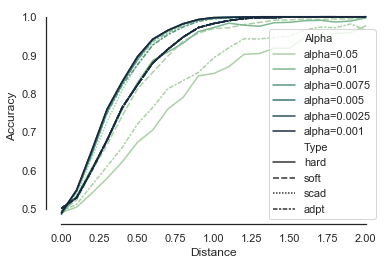

In [7]:
#datas=data[data.method=='LDAS']
data_ldas=data.query("method=='LDAS'")
data_ldas['Alpha']='alpha='+data_ldas.alf.astype('str')
#in order to make alf recognized as factor by hue in seaborn, convert alf into string that unablt to be interpreted as numric

sns.set(style="white")
sns.lineplot(x="Distance", y="Accuracy",
             hue="Alpha",style='Type',
             palette="ch:r=-.5,l=.75",
             data=data_ldas,ci=None)
sns.despine(trim=True)

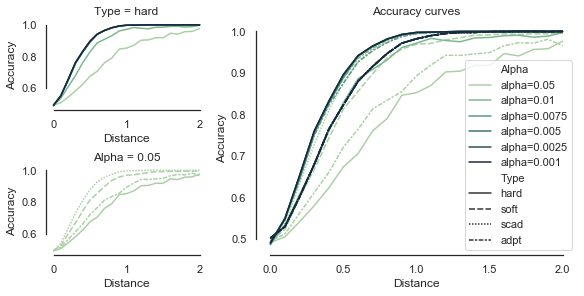

In [8]:
fig3 = plt.figure(constrained_layout=True,figsize=[8,4])
gs = fig3.add_gridspec(2, 3)
f3_ax1 = fig3.add_subplot(gs[:,1:])
sns.set(style="white")
sns_plot=sns.lineplot(x="Distance", y="Accuracy",
             hue="Alpha",style='Type',
             palette="ch:r=-.5,l=.75",
             data=data_ldas,ci=None)
sns.despine(trim=True)
sns_plot.set_title('Accuracy curves')
#sns_plot.set(xlabel='Distance', ylabel='Accuracy')

f3_ax2 = fig3.add_subplot(gs[0,0])
sns.set(style="white")
sns.lineplot(x="Distance", y="Accuracy",
             hue="Alpha",
             palette="ch:r=-.5,l=.75",
             data=data_ldas.query("Type=='hard'"),ci=None,
            legend=None).set_title('Type = hard')
sns.despine(trim=True)

f3_ax3 = fig3.add_subplot(gs[1,0])
sns.set(style="white")
sns.lineplot(x="Distance", y="Accuracy",
             hue="Alpha",style='Type',
             palette="ch:r=-.5,l=.75",
             data=data_ldas.query("alf==0.05"),ci=None,
            legend=None).set_title('Alpha = 0.05')  
sns.despine(trim=True)
plt.show()
fig.savefig('arm_sim.eps', format='eps', dpi=100)

<Figure size 576x288 with 0 Axes>

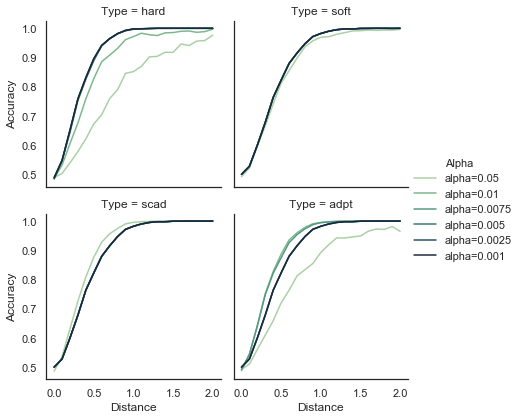

In [9]:
fig3 = plt.figure(constrained_layout=True,figsize=[8,4])
sns.set(style="white")
sns.relplot(x="Distance", y="Accuracy",
            hue="Alpha",
            col='Type',col_wrap=2,height=3,
            palette="ch:r=-.5,l=.75",kind='line',
            data=data_ldas,ci=None)

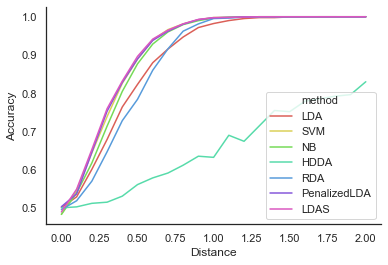

In [10]:
data_method=data[(data.method!='LDAS')]
data_LDAS=data_ldas.query("Type == 'hard'& alf == 0.001")
sns_plot=sns.lineplot(x="Distance", y="Accuracy", 
                      hue='method',
                      palette=sns.color_palette("hls", 7),
                      data=data_method.append(data_LDAS),ci=None)
sns.despine()

## unbalanced

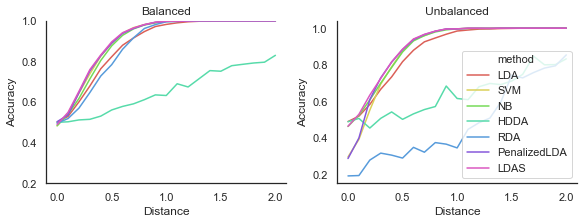

In [11]:
fig3 = plt.figure(constrained_layout=True,figsize=[8,3])
gs = fig3.add_gridspec(1, 2)
f3_ax1 = fig3.add_subplot(gs[0,0])
sns_plot=sns.lineplot(x="Distance", y="Accuracy", 
                      hue='method',
                      palette=sns.color_palette("hls", 7),
                      data=data_method.append(data_LDAS),ci=None,legend=None).set_title('Balanced')
plt.ylim(0.2, 1.0)
sns.despine()
f3_ax1 = fig3.add_subplot(gs[0,1])

data2=pd.read_csv('simulation/simulation_arm_unbalance.csv')
data2=data2.rename({'t': 'Distance', 'prec': 'Accuracy','type':'Type'}, axis='columns')
data_method2=data2[(data2.method!='LDAS')]
data_LDAS2=data2.query("method=='LDAS'").query("Type == 'hard'& alf == 0.001")

sns_plot=sns.lineplot(x="Distance", y="Accuracy", 
                      hue='method',
                      palette=sns.color_palette("hls", 7),
                      data=data_method2.append(data_LDAS2).query('ytrue==0'),ci=None).set_title('Unbalanced')
sns.despine()
fig.savefig('method.eps', format='eps', dpi=100)

# Real data
## khan data

In [12]:
real=pd.read_csv('real/khan.csv')
real_CV=pd.read_csv('real/khan_CV.csv')
real_data=pd.merge(real, real_CV, on=['index', 'index'])
real_data['Accuracy']=real_data.ytrue==real_data.ypred
real_method=real_data.query("method!='LDAS'")
real_ldas=real_data.query("method=='LDAS'")
CV_method=real_method.groupby(['method','fold'],as_index=False).mean()
CV_ldas=real_ldas.groupby(['alf','type','fold'],as_index=False).mean()

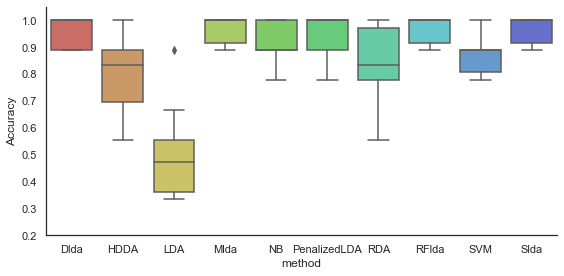

In [13]:
sns_plot=sns.catplot(x='method',y='Accuracy',data=CV_method,
           palette=sns.color_palette("hls", 14)[:-4],
           kind='box',
           height=4, aspect=2)
plt.ylim(0.2,1.05)
plt.savefig('MP_methods.png', format='png', dpi=100)

(0.2, 1.05)

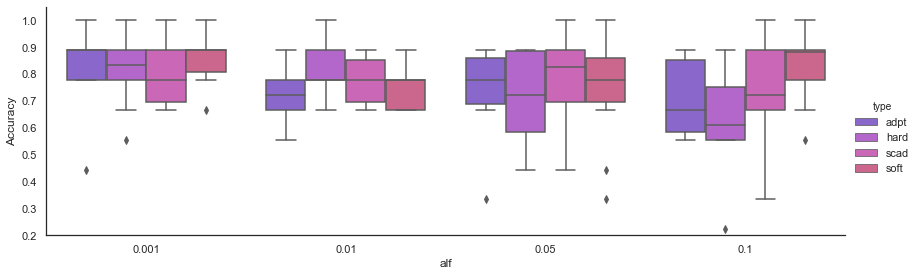

In [14]:
sns_plot = sns.catplot(x='alf',y='Accuracy',hue="type",data=CV_ldas,
           palette=sns.color_palette("hls",14)[-4:],
           kind='box',
           height=4, aspect=3)
plt.ylim(0.2,1.05)

## MP data

In [15]:
real=pd.read_csv('real/MP.csv')
real_CV=pd.read_csv('real/MP_CV.csv')
real_data=pd.merge(real, real_CV, on=['index', 'index'])
real_data['Accuracy']=real_data.ytrue==real_data.ypred
real_method=real_data.query("method!='LDAS'")
real_ldas=real_data.query("method=='LDAS'")
CV_method=real_method.groupby(['method','fold'],as_index=False).mean()
CV_ldas=real_ldas.groupby(['alf','type','fold'],as_index=False).mean()

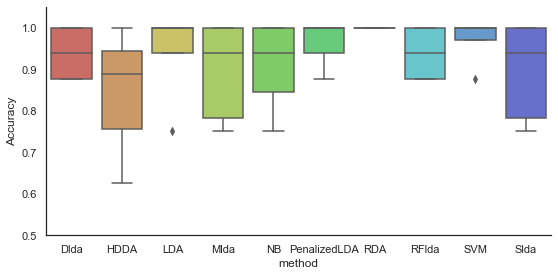

In [16]:
sns_plot=sns.catplot(x='method',y='Accuracy',data=CV_method,
           palette=sns.color_palette("hls", 14)[:-4],
           kind='box',
           height=4, aspect=2)
plt.ylim(0.5,1.05)
plt.savefig('MP_methods.png', format='png', dpi=100)

(0.5, 1.05)

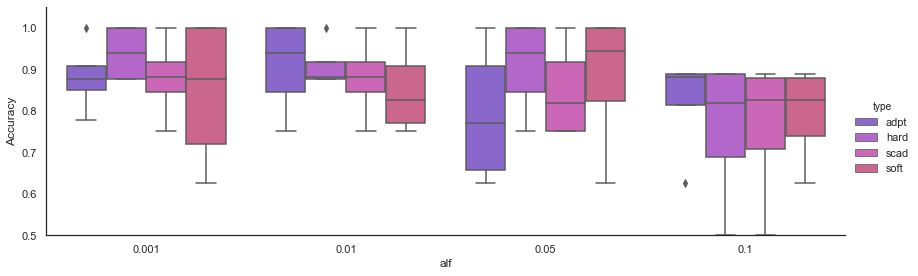

In [17]:
sns_plot = sns.catplot(x='alf',y='Accuracy',hue="type",data=CV_ldas,
           palette=sns.color_palette("hls",14)[-4:],
           kind='box',
           height=4, aspect=3)
plt.ylim(0.5,1.05)